In [93]:
from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings

embedding_function = OpenAIEmbeddings(model='text-embedding-3-large')

vector_store = Chroma(
    embedding_function=embedding_function,
    collection_name="income_tax_collection",
    persist_directory="./income_tax_collection"
)

retriever = vector_store.as_retriever(search_kwargs={"k": 3})

In [94]:
from typing_extensions import List, TypedDict
from langchain_core.documents import Document
from langgraph.graph import StateGraph

class AgentState(TypedDict):
    query: str
    context: List[Document]
    answer: str

graph_builder = StateGraph(AgentState)

In [95]:
def retrieve(state : AgentState):
  query = state['query']
  docs = retriever.invoke(query)
  return {'context': docs}

In [96]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model='gpt-4o', temperature=0)

In [97]:
from langsmith import Client

client = Client()
generate_prompt = client.pull_prompt("rlm/rag-prompt", include_model=True)
generate_llm = ChatOpenAI(model='gpt-4o', max_completion_tokens=100)
def generate(state: AgentState):
  context = state['context']
  query = state['query']
  rag_chain = generate_prompt | generate_llm
  response = rag_chain.invoke({'question': query, 'context': context})
  return {'answer' : response.content}

In [98]:
from typing import Literal

# 문서 관련성 평가 프롬프트 불러오기 (doc_relevance_prompt 변수에 저장)
client = Client()
doc_relevance_prompt = client.pull_prompt("langchain-ai/rag-document-relevance", include_model=True)

def check_doc_relevance(state: AgentState) -> Literal['relevant', 'irrelevant']:
    query = state["query"]
    context = state['context']
    doc_relevance_chain = doc_relevance_prompt | llm
    response = doc_relevance_chain.invoke({'question': query, 'documents': context})
    if response['Score'] == 1:
        return 'relevant'

    return 'irrelevant'

In [99]:
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser
dictionary = ['사람과 관련된 표현자 -> 거주자']

rewrite_prompt = PromptTemplate.from_template("""
사용자의 질문을 보고, 우리의 사전을 참고해서 사용자의 질문을 변경해주세요.
사전 : {dictionary}
질문 : {{query}} 
""")

def rewrite(state: AgentState):
    query = state['query']
    rewrite_chain = rewrite_prompt | llm | StrOutputParser()
    response = rewrite_chain.invoke({'query': query})
    return {'query': response}

In [100]:
from langchain_core.prompts import PromptTemplate

hallucination_prompt = PromptTemplate.from_template("""
You are a teacher tasked with evaluating whether a student's answer is based on facts or not.
Given documents (excerpts from income tax law) and a student's answer:

IMPORTANT:
- If the student's answer is based on the documents, respond with exactly: not hallucinated
- If the student's answer is not based on the documents, respond with exactly: hallucinated
- Output must be ONE of the two labels only. No explanation, no punctuation.

documents:
{documents}

student_answer:
{student_answer}
""".strip())

hallucination_llm = ChatOpenAI(model='gpt-4o', temperature=0)

def check_hallucination(state : AgentState) -> Literal['hallucinated', 'not hallucinated']:
  answer = state['answer']
  context = state['context']
  context = [doc.page_content for doc in context]
  hallucination_chain = hallucination_prompt | hallucination_llm | StrOutputParser()
  response = hallucination_chain.invoke({'student_answer': answer, 'documents': context})
  print(f'hallucination check response: {response}')
  return response

In [101]:
client = Client()
helpfulness_prompt = client.pull_prompt("langchain-ai/rag-answer-helpfulness", include_model=True)

def check_helpfulness_grader(state : AgentState):
  query = state['query']
  answer = state['answer']
  helpfulness_chain = helpfulness_prompt | llm
  response = helpfulness_chain.invoke({'question': query, 'student_answer': answer})
  print(f'helpfulness check response: {response}')
  if response['Score'] == 1:
      return 'helpful'
  
  return 'not helpful'


def check_helpfulness(state : AgentState):
  return state

In [102]:
query = '연봉 5천만원인 거주지의 소득세는 얼마인가요?'

context = retriever.invoke(query)

for document in context:
    print(document.page_content)

generate_state = {'query': query, 'context': context}

answer = generate(generate_state)
print(f'Answer: {answer["answer"]}')

helpfulness_state = {'answer' : answer, 'query' : query}

check_helpfulness(helpfulness_state)

② 제70조제1항, 제70조의2에 따른 제74조에 따라 차례로 할 것이 제70조제1항제2호에 따르며 서류를 제출하여야 한다는 경우에는 기준소득 중 거주자 본인이 된다(분산)과 제70조제2와 제74조에 따른 제료 및 제대법을 포함한다. 단, 차별제표청정인 그 업체를 남겨 제출한 경우로 그에 대하여 아니하다.<개정 2013. 1. 1.>
  ③ 제80조에 따른 수익과 관련의 경우에는 기초공제 중 거주자 본인이 된다(분산)과 그에 관한 적지사항을 분명히 한다.
[전문개정 2009. 12. 31.]
[제목개정 2014. 1. 1.]
제54조의2(공동사업에 대한 소득공제 등 특례) 제51조의3 또는 「조세특례제한법」에 따른 소득공제를 적용하거나 제59조의2에 따른 세액감면을 적용하는 경우 제54조제3항에 따라 공동사업자의 소득에 합산과세되는 특별세액거래의 지출․납입․투자 등의 금액이 있을 경우 주된 공동사업자의 소득에 합산과세되는 소득금액에 합산되어 주된 공동사업자의 합산과세세액은 공동사업소득액 또는 공동사업창출세액을 계산할 때 소득공제 또는 세액공제를 받을 수 있다. 
[개정 2014. 1. 1.]
[전문개정 2009. 12. 31.]
[제목개정 2014. 1. 1.]
제2절 세액의 계산 <개정 2009. 12. 31.>
제1관 세율 <개정 2009. 12. 31.>
제55조(세율) 거주자의 종합소득에 대한 소득세는 해당 연도의 종합소득과세표준에 다음의 세율을 적용하여 계산한 금액(이하 "종합소득과세표준세액"이라 한다)을 그 세액으로 한다. <개정 2014. 1. 1., 2016. 12. 20., 2017. 12. 19., 2020. 12. 29., 2022. 12. 31.>
종합소득
┌───────────────┐
│ 과세표준의 6개 구간 │
├───────────────┤
│ 1,400만원 이하        │ 84만원 + (1,400만원을 초과하는 금액의 15%)  │
│ 1,400만원 초과        │ 84만원 + (5,000만원을 초과하는 금액의 24%)

{'answer': {'answer': '연봉 5천만원인 거주자의 소득세는 624만원입니다. 이는 5,000만원 이하의 과세 표준에 대해 84만원 + (1,400만원을 초과하는 금액의 15%)를 적용하여 계산한 금액입니다.'},
 'query': '연봉 5천만원인 거주지의 소득세는 얼마인가요?'}

In [103]:
graph_builder.add_node('retrieve', retrieve)
graph_builder.add_node('generate', generate)
graph_builder.add_node('rewrite', rewrite)
graph_builder.add_node('check_helpfulness', check_helpfulness)

In [104]:
from langgraph.graph import START, END

graph_builder.add_edge(START, 'retrieve')
graph_builder.add_conditional_edges(
  'retrieve',
  check_doc_relevance,
  {
    'relevant': 'generate',
    'irrelevant': END
  }
)
graph_builder.add_conditional_edges(
  'generate',
  check_hallucination,
  {
    'not hallucinated': 'check_helpfulness',
    'hallucinated': 'generate'
  }
)
graph_builder.add_conditional_edges(
  'check_helpfulness',
  check_helpfulness_grader,
  {
    'helpful': END,
    'not helpful': 'rewrite'
  }
)
graph_builder.add_edge('rewrite', 'retrieve')

In [105]:
graph = graph_builder.compile()

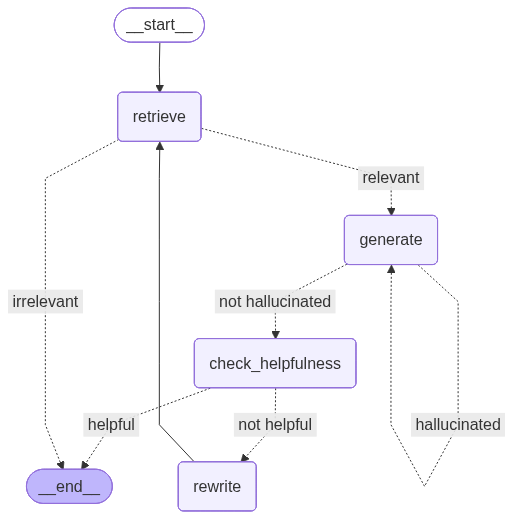

In [106]:
from IPython.display import Image, display

png_bytes = graph.get_graph().draw_mermaid_png()
display(Image(data=png_bytes))

In [108]:
initial_state = {'query' : '연봉 5천만원인 거주자가 납부해야 하는 소득세는 얼마인가요?'}
graph.invoke(initial_state)

hallucination check response: hallucinated
hallucination check response: hallucinated
hallucination check response: not hallucinated
helpfulness check response: {'Score': 1, 'Explanation': 'The student\'s answer is concise and directly addresses the question. The question asks for the amount of income tax a resident with an annual salary of 50 million won has to pay. The student correctly identifies the tax bracket ("1,400만원 초과 8,800만원 이하") and provides the calculated tax amount (624만원). This answer is relevant and helps to answer the question, meeting all the criteria for a score of 1.'}


{'query': '연봉 5천만원인 거주자가 납부해야 하는 소득세는 얼마인가요?',
 'context': [Document(id='f11921a1-2218-442d-a550-4d8dc8ff082e', metadata={'source': './document/income_tax.txt'}, page_content='② 제70조제1항, 제70조의2에 따른 제74조에 따라 차례로 할 것이 제70조제1항제2호에 따르며 서류를 제출하여야 한다는 경우에는 기준소득 중 거주자 본인이 된다(분산)과 제70조제2와 제74조에 따른 제료 및 제대법을 포함한다. 단, 차별제표청정인 그 업체를 남겨 제출한 경우로 그에 대하여 아니하다.<개정 2013. 1. 1.>\n  ③ 제80조에 따른 수익과 관련의 경우에는 기초공제 중 거주자 본인이 된다(분산)과 그에 관한 적지사항을 분명히 한다.\n[전문개정 2009. 12. 31.]\n[제목개정 2014. 1. 1.]\n제54조의2(공동사업에 대한 소득공제 등 특례) 제51조의3 또는 「조세특례제한법」에 따른 소득공제를 적용하거나 제59조의2에 따른 세액감면을 적용하는 경우 제54조제3항에 따라 공동사업자의 소득에 합산과세되는 특별세액거래의 지출․납입․투자 등의 금액이 있을 경우 주된 공동사업자의 소득에 합산과세되는 소득금액에 합산되어 주된 공동사업자의 합산과세세액은 공동사업소득액 또는 공동사업창출세액을 계산할 때 소득공제 또는 세액공제를 받을 수 있다. \n[개정 2014. 1. 1.]\n[전문개정 2009. 12. 31.]\n[제목개정 2014. 1. 1.]\n제2절 세액의 계산 <개정 2009. 12. 31.>\n제1관 세율 <개정 2009. 12. 31.>\n제55조(세율) 거주자의 종합소득에 대한 소득세는 해당 연도의 종합소득과세표준에 다음의 세율을 적용하여 계산한 금액(이하 "종합소득과세표준세액"이라 한다)을 그 세액으로 한다. <개정 2014. 1. 1., 2016. 12. 20., 2017. 12. 19., 2020. 12.